In [141]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [142]:
np.random.seed(42)
tf.random.set_seed(42)

In [143]:
height= 224
width= 224
batch_size= 32

In [144]:
train_dir = 'car_data/train'
test_dir = 'car_data/test'

In [145]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [146]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= (height, width),
    batch_size= batch_size,
    class_mode= 'categorical',
    shuffle=True,
)

Found 8144 images belonging to 196 classes.


In [147]:
val_data= val_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size= batch_size,
    class_mode='categorical',
    shuffle=False,
)

Found 8041 images belonging to 196 classes.


In [148]:
train_generator.class_indices

{'AM General Hummer SUV 2000': 0,
 'Acura Integra Type R 2001': 1,
 'Acura RL Sedan 2012': 2,
 'Acura TL Sedan 2012': 3,
 'Acura TL Type-S 2008': 4,
 'Acura TSX Sedan 2012': 5,
 'Acura ZDX Hatchback 2012': 6,
 'Aston Martin V8 Vantage Convertible 2012': 7,
 'Aston Martin V8 Vantage Coupe 2012': 8,
 'Aston Martin Virage Convertible 2012': 9,
 'Aston Martin Virage Coupe 2012': 10,
 'Audi 100 Sedan 1994': 11,
 'Audi 100 Wagon 1994': 12,
 'Audi A5 Coupe 2012': 13,
 'Audi R8 Coupe 2012': 14,
 'Audi RS 4 Convertible 2008': 15,
 'Audi S4 Sedan 2007': 16,
 'Audi S4 Sedan 2012': 17,
 'Audi S5 Convertible 2012': 18,
 'Audi S5 Coupe 2012': 19,
 'Audi S6 Sedan 2011': 20,
 'Audi TT Hatchback 2011': 21,
 'Audi TT RS Coupe 2012': 22,
 'Audi TTS Coupe 2012': 23,
 'Audi V8 Sedan 1994': 24,
 'BMW 1 Series Convertible 2012': 25,
 'BMW 1 Series Coupe 2012': 26,
 'BMW 3 Series Sedan 2012': 27,
 'BMW 3 Series Wagon 2012': 28,
 'BMW 6 Series Convertible 2007': 29,
 'BMW ActiveHybrid 5 Sedan 2012': 30,
 'BMW 

In [149]:
images, labels = next(train_generator)

In [150]:
images.shape

(32, 224, 224, 3)

In [151]:
labels.shape

(32, 196)

In [154]:
num_classes = len(np.unique(train_generator.labels))
num_classes

196

In [155]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

# Residual Block with Bottleneck (for deeper ResNets)
def bottleneck_residual_block(x, filters, stride=1, use_batch_norm=True):
    shortcut = x

    # Reduce dimensionality with 1x1 convolution
    x = layers.Conv2D(filters // 4, kernel_size=1, strides=1, padding='same', activation=None)(x)
    if use_batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Main 3x3 convolution
    x = layers.Conv2D(filters // 4, kernel_size=3, strides=stride, padding='same', activation=None)(x)
    if use_batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Restore dimensionality with 1x1 convolution
    x = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same', activation=None)(x)
    if use_batch_norm:
        x = layers.BatchNormalization()(x)

    # Adjust shortcut dimensions if necessary
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
    
    # Add shortcut and apply ReLU
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

# Residual Block for shallower ResNets
def basic_residual_block(x, filters, kernel_size=3, stride=1, use_batch_norm=True):
    shortcut = x

    # First convolution
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation=None)(x)
    if use_batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', activation=None)(x)
    if use_batch_norm:
        x = layers.BatchNormalization()(x)

    # Add the shortcut connection
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

# Build ResNet Model with flexible blocks
def build_resnet(input_shape, num_classes, depth='basic'):
    assert depth in ['basic', 'bottleneck'], "depth must be 'basic' or 'bottleneck'"

    residual_block = basic_residual_block if depth == 'basic' else bottleneck_residual_block

    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Add residual blocks
    for filters, blocks, stride in [(64, 2, 1), (128, 2, 2), (256, 4, 2), (512, 2, 2)]:
        for block_idx in range(blocks):
            x = residual_block(x, filters, stride=stride if block_idx == 0 else 1)

    # Global Average Pooling and Output
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Define input shape and number of classes
input_shape = (height, width, 3)
num_classes = train_generator.num_classes

# Build and compile the model
resnet_model = build_resnet(input_shape, num_classes, depth='basic')
resnet_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Model summary
resnet_model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_148 (Conv2D)            (None, 112, 112, 64  9472        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_133 (Batch  (None, 112, 112, 64  256        ['conv2d_148[0][0]']             
 Normalization)                 )                                                           

In [156]:
checkpoint = ModelCheckpoint('best_weights.keras', monitor='val_accuracy', save_best_only=True, mode='max')

In [157]:
# Train the model
history = resnet_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_data,
    callbacks=[checkpoint]
)

Epoch 1/30
255/255 [==============================] - 198s 752ms/step - loss: 5.3690 - accuracy: 0.0087 - val_loss: 5.2893 - val_accuracy: 0.0055
Epoch 2/30
255/255 [==============================] - 146s 571ms/step - loss: 5.1980 - accuracy: 0.0101 - val_loss: 5.3327 - val_accuracy: 0.0103
Epoch 3/30
255/255 [==============================] - 151s 591ms/step - loss: 5.1540 - accuracy: 0.0125 - val_loss: 5.6060 - val_accuracy: 0.0087
Epoch 4/30
255/255 [==============================] - 129s 507ms/step - loss: 5.1190 - accuracy: 0.0133 - val_loss: 5.9656 - val_accuracy: 0.0099
Epoch 5/30
255/255 [==============================] - 133s 524ms/step - loss: 5.0661 - accuracy: 0.0177 - val_loss: 5.7778 - val_accuracy: 0.0108
Epoch 6/30
255/255 [==============================] - 167s 655ms/step - loss: 5.0085 - accuracy: 0.0237 - val_loss: 5.5296 - val_accuracy: 0.0141
Epoch 7/30
255/255 [==============================] - 123s 482ms/step - loss: 4.9481 - accuracy: 0.0264 - val_loss: 5.3022 -

In [158]:
# Evaluate the model on the validation data
val_loss, val_accuracy = resnet_model.evaluate(val_data)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

252/252 [==============================] - 25s 98ms/step - loss: 2.5236 - accuracy: 0.4000
Validation Loss: 2.523560047149658
Validation Accuracy: 0.3999502658843994


In [159]:
# Get predictions on validation data
val_data.reset()  # Reset the generator for evaluation
predictions = resnet_model.predict(val_data)
predicted_classes = np.argmax(predictions, axis=1)

252/252 [==============================] - 24s 94ms/step


In [160]:
print(predicted_classes)

[  0 148   0 ... 191   5 195]


In [161]:
# Get true labels from the validation data generator
true_classes = val_data.classes  # This gives the true labels

# Generate classification report
class_labels = list(val_data.class_indices.keys())  # Get class labels
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Convert the report to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Convert metrics to percentage
report_df['precision'] = report_df['precision'] * 100
report_df['recall'] = report_df['recall'] * 100
report_df['f1-score'] = report_df['f1-score'] * 100
report_df['support'] = report_df['support'].astype(int)

# Display the classification report
print(report_df[['precision', 'recall', 'f1-score', 'support']])

                               precision     recall   f1-score  support
AM General Hummer SUV 2000     60.869565  63.636364  62.222222       44
Acura Integra Type R 2001      51.351351  43.181818  46.913580       44
Acura RL Sedan 2012            60.000000  46.875000  52.631579       32
Acura TL Sedan 2012            75.862069  51.162791  61.111111       43
Acura TL Type-S 2008           54.545455  14.285714  22.641509       42
...                                  ...        ...        ...      ...
Volvo XC90 SUV 2007            78.947368  34.883721  48.387097       43
smart fortwo Convertible 2012  52.941176  45.000000  48.648649       40
accuracy                       39.995025  39.995025  39.995025        0
macro avg                      50.123869  39.981976  39.711739     8041
weighted avg                   49.898728  39.995025  39.595599     8041

[199 rows x 4 columns]


c:\Users\medoo\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\medoo\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\medoo\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


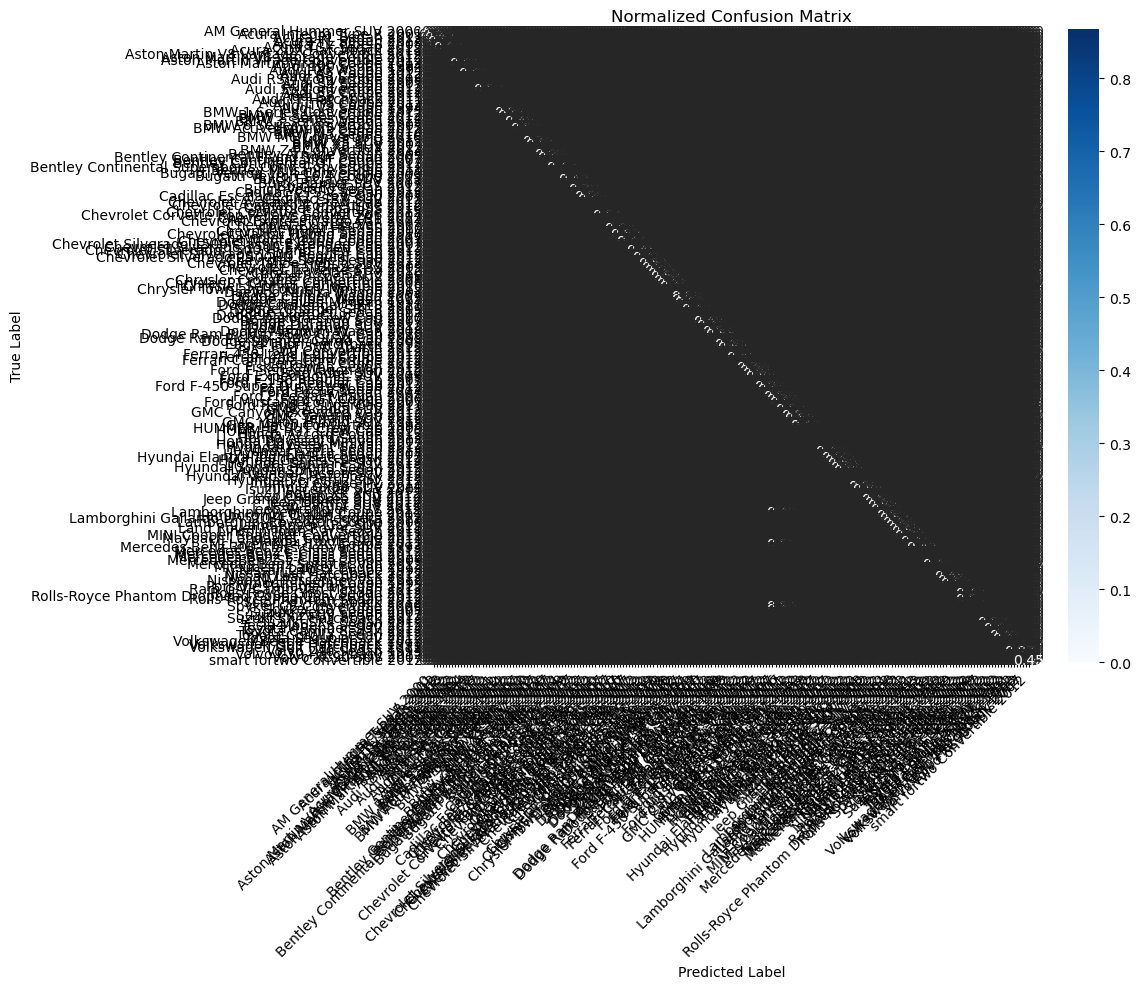

In [162]:
# Compute confusion matrix and normalize it
conf_matrix = confusion_matrix(true_classes, predicted_classes)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plotting Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, cbar=True)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Normalized Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

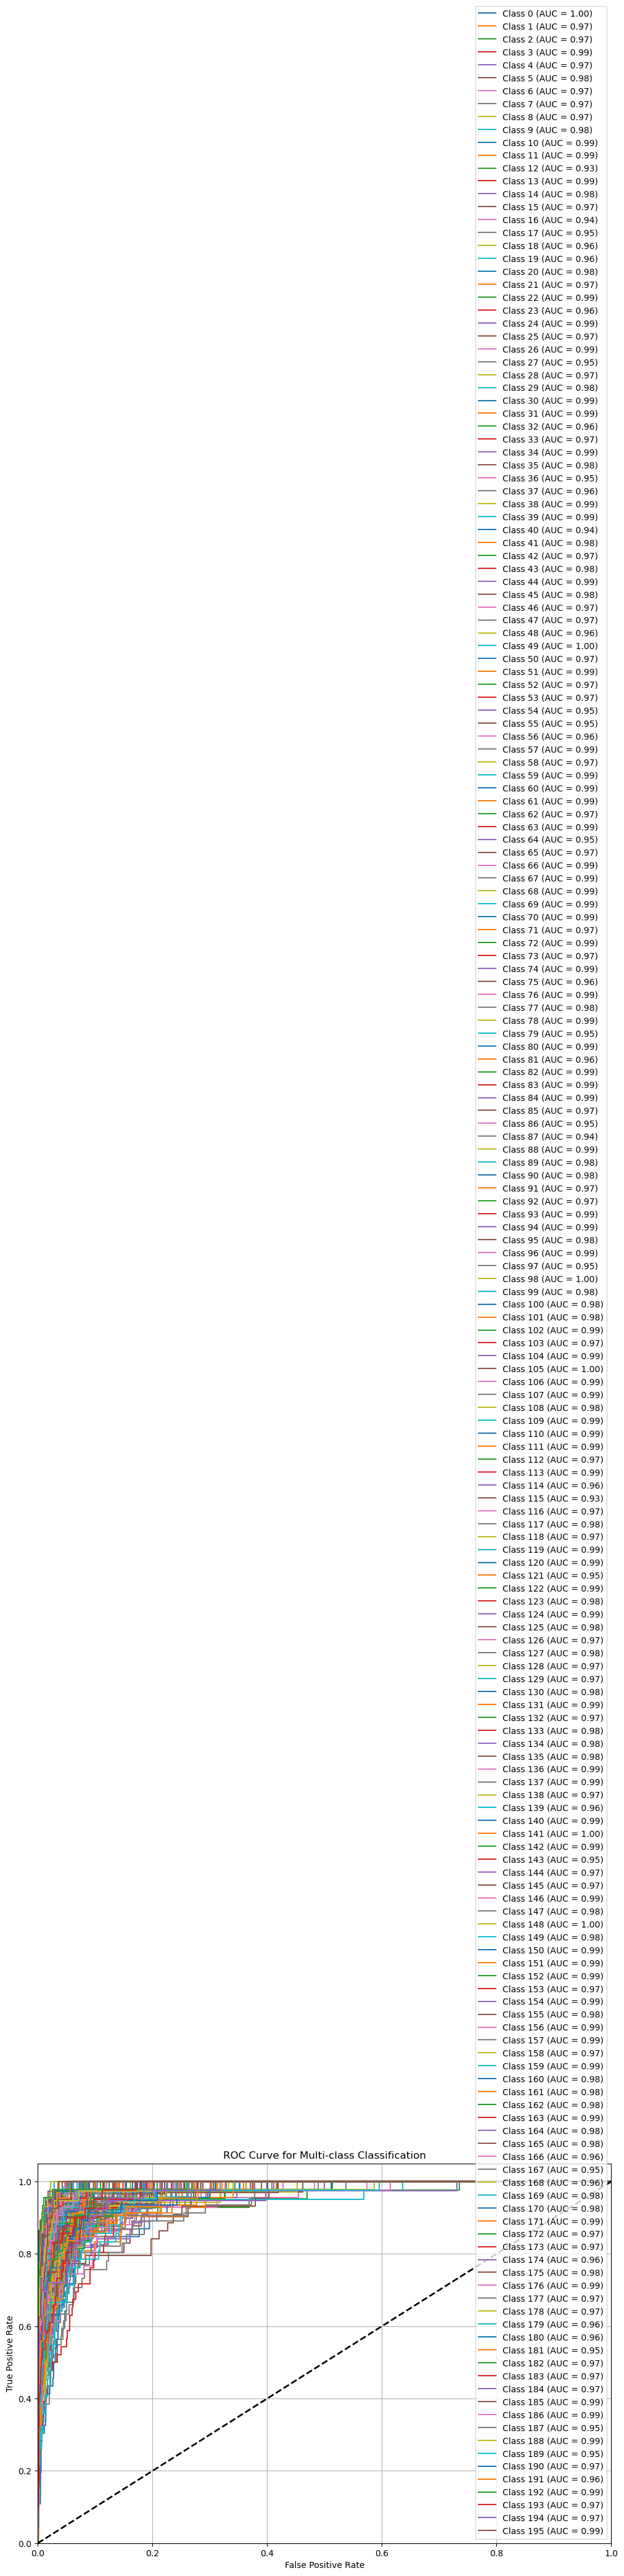

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get true labels from the validation data generator
true_classes = val_data.classes  # This gives the true labels

# Binarize the output labels for multi-class ROC
n_classes = len(val_data.class_indices)  # Number of classes
true_classes_binarized = label_binarize(true_classes, classes=range(n_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plotting the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [164]:
def plot_learning_curve(history, metrics):
    acc = history.history[metrics]
    val_acc = history.history[f'val_{metrics}']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(5,3))
    plt.plot(epochs, acc, label=f'training {metrics}')
    plt.plot(epochs, val_acc, label=f'validation {metrics}')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend()

    plt.figure(figsize=(5,3))
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

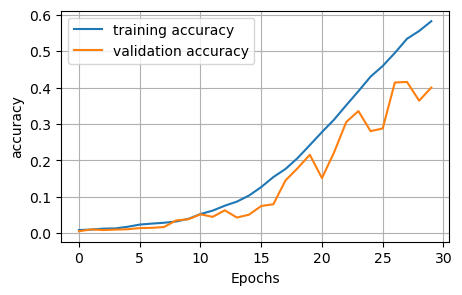

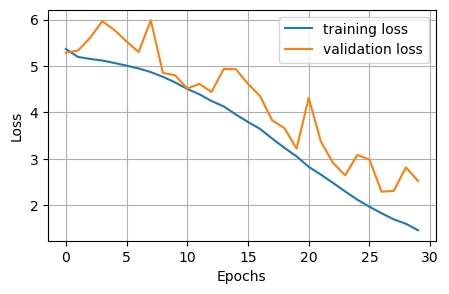

In [165]:
plot_learning_curve(history, metrics='accuracy')

In [166]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [167]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('best_weights.keras')

In [168]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def prediction(image_path, model, class_indices, target_size=(height, width)):

    # Preprocess the image
    def preprocess_image(image_path, target_size=(height, width)):
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        return np.expand_dims(img_array, axis=0)

    # Preprocess the input image
    preprocessed_image = preprocess_image(image_path, target_size)

    # Make prediction
    predictions = model.predict(preprocessed_image)
    predicted_label = np.argmax(predictions, axis=1)[0]

    # Map the predicted label to the class name
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[predicted_label]

    # Display the image with the prediction
    img = load_img(image_path, target_size=target_size)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

1/1 [==============================] - 0s 295ms/step


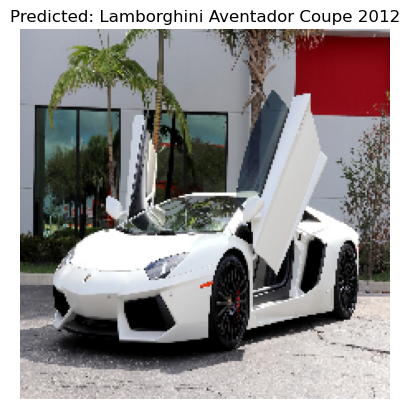

The predicted class is: Lamborghini Aventador Coupe 2012


In [169]:
# Call the function
image_path = "C:\\Users\\medoo\\OneDrive\\Desktop\\Used-2012-Lamborghini-Aventador-LP-700-4.jpg"
predicted_class = prediction(image_path, model, train_generator.class_indices)

print(f"The predicted class is: {predicted_class}")